#Câu a

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 15.0 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824028 sha256=cc2c7c4270b26ab032a875f47033f9dc270f39457c3e770b41f07b7ecb1ae015
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Lưu vào drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
id='1E-voIV2ctU4Brw022Na8RHVVRGOoNkO1'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('data.txt')

id='1yXNlZWMqUcAwDScBrkFChOHJwR1FZXmI'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('c1.txt')

id='1vfovle9DgaeK0LnbQTH0j7kRaJjsvLtb'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('c2.txt')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

In [ ]:
# Tạo session
conf = SparkConf().set("spark.ui.port", "4050")

# Tạo context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [ ]:
def parseVector(line):
  return np.array([float(x) for x in line.split(" ")])

In [ ]:
def closestPoint(p, centroids, method = 'd2'):
  bestIndex = -1
  distance = float("+inf")
  for i in range(len(centroids)):
    if method == 'd2':
      temp_distance = np.sum((p - centroids[i]) ** 2)
    elif method == 'd1':
      temp_distance = np.sum(np.abs(p - centroids[i]))

    if temp_distance < distance:
      distance = temp_distance
      bestIndex = i

  return bestIndex, distance

In [ ]:
data = spark.read.text('data.txt').rdd.map(lambda x: x[0]).map(parseVector)
c1 = np.loadtxt('c1.txt', delimiter = ' ')
c2 = np.loadtxt('c2.txt', delimiter = ' ')

In [ ]:
MAX_ITER = 20

In [ ]:
centroids1 = c1.copy()
centroids2 = c2.copy()

error_c1_Euclidean_distance = []
error_c2_Euclidean_distance = []

for ITER in range(MAX_ITER):
  closest = data.map(lambda p: (closestPoint(p, centroids1, 'd2')[0], (p, 1, closestPoint(p, centroids1, 'd2')[1])))
  pointStats = closest.reduceByKey(lambda p1_c1, p2_c2: (p1_c1[0] + p2_c2[0], p1_c1[1] + p2_c2[1]))
  newCentroids = pointStats.map(lambda st: (st[0], st[1][0] / st[1][1])).collect()

  error = np.sum(np.array(list(x[1][2] for x in closest.collect())))
  error_c1_Euclidean_distance.append(error)

  for (i, p) in newCentroids:
    centroids1[i] = p

for ITER in range(MAX_ITER):
  closest = data.map(lambda p: (closestPoint(p, centroids2, 'd2')[0], (p, 1, closestPoint(p, centroids2, 'd2')[1])))
  pointStats = closest.reduceByKey(lambda p1_c1, p2_c2: (p1_c1[0] + p2_c2[0], p1_c1[1] + p2_c2[1]))
  newCentroids = pointStats.map(lambda st: (st[0], st[1][0] / st[1][1])).collect()

  error = np.sum(np.array(list(x[1][2] for x in closest.collect())))
  error_c2_Euclidean_distance.append(error)

  for (i, p) in newCentroids:
    centroids2[i] = p

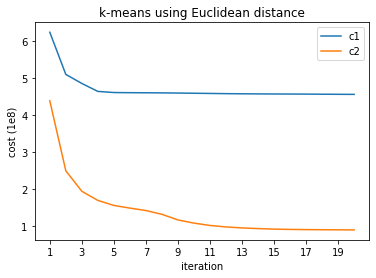

In [ ]:
plt.figure()
plt.plot(list(range(1, 21)), np.array(error_c1_Euclidean_distance) / 100000000, label ='c1')
plt.plot(list(range(1, 21)), np.array(error_c2_Euclidean_distance) / 100000000, label = 'c2')
plt.xticks(list(range(1, 21, 2)))
plt.xlabel('iteration')
plt.ylabel('cost (1e8)')
plt.title('k-means using Euclidean distance')
plt.legend(['c1', 'c2'])
plt.savefig('Euclidean_distance.png')
plt.show()

In [ ]:
print("Phần trăm thay đổi ở c1 bằng Euclidean distance là :{}".format((error_c1_Euclidean_distance[0] - error_c1_Euclidean_distance[10]) / error_c1_Euclidean_distance[0]))
print("Phần trăm thay đổi ở c2 bằng Euclidean distance là :{}".format((error_c2_Euclidean_distance[0] - error_c2_Euclidean_distance[10]) / error_c2_Euclidean_distance[0]))

Phần trăm thay đổi ở c1 bằng Euclidean distance là :0.2648391714456054
Phần trăm thay đổi ở c2 bằng Euclidean distance là :0.7669795594605942


#Câu b

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
openjdk-8-jdk-headless is already the newest version (8u362-ga-0ubuntu1~20.04.1).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.


In [ ]:
id='1E-voIV2ctU4Brw022Na8RHVVRGOoNkO1'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('data.txt')

id='1yXNlZWMqUcAwDScBrkFChOHJwR1FZXmI'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('c1.txt')

id='1vfovle9DgaeK0LnbQTH0j7kRaJjsvLtb'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('c2.txt')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
     

In [ ]:
def parseVector(line):
  return np.array([float(x) for x in line.split(" ")])

def closestPoint(p, centroids, method = 'd2'):
  bestIndex = -1
  distance = float("+inf")
  for i in range(len(centroids)):
    if method == 'd2':
      temp_distance = np.sum((p - centroids[i]) ** 2)
    elif method == 'd1':
      temp_distance = np.sum(np.abs(p - centroids[i]))

    if temp_distance < distance:
      distance = temp_distance
      bestIndex = i

  return bestIndex, distance
     

In [ ]:
data = spark.read.text('data.txt').rdd.map(lambda x: x[0]).map(parseVector)
c1 = np.loadtxt('c1.txt', delimiter = ' ')
c2 = np.loadtxt('c2.txt', delimiter = ' ')

In [ ]:
MAX_ITER = 20

centroids1 = c1.copy()
centroids2 = c2.copy()

error_c1_Manhattan_distance = []
error_c2_Manhattan_distance = []

for ITER in range(MAX_ITER):
  closest = data.map(lambda p: (closestPoint(p, centroids1, 'd1')[0], (p, 1, closestPoint(p, centroids1, 'd1')[1])))
  pointStats = closest.reduceByKey(lambda p1_c1, p2_c2: (p1_c1[0] + p2_c2[0], p1_c1[1] + p2_c2[1]))
  newCentroids = pointStats.map(lambda st: (st[0], st[1][0] / st[1][1])).collect()

  error = np.sum(np.array(list(x[1][2] for x in closest.collect())))
  error_c1_Manhattan_distance.append(error)

  for (i, p) in newCentroids:
    centroids1[i] = p

for ITER in range(MAX_ITER):
  closest = data.map(lambda p: (closestPoint(p, centroids2, 'd1')[0], (p, 1, closestPoint(p, centroids2, 'd1')[1])))
  pointStats = closest.reduceByKey(lambda p1_c1, p2_c2: (p1_c1[0] + p2_c2[0], p1_c1[1] + p2_c2[1]))
  newCentroids = pointStats.map(lambda st: (st[0], st[1][0] / st[1][1])).collect()

  error = np.sum(np.array(list(x[1][2] for x in closest.collect())))
  error_c2_Manhattan_distance.append(error)

  for (i, p) in newCentroids:
    centroids2[i] = p

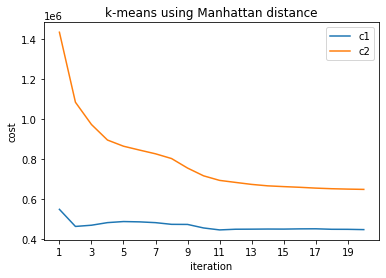

In [ ]:
plt.figure()
plt.plot(list(range(1, 21)), np.array(error_c1_Manhattan_distance), label = 'c1')
plt.plot(list(range(1, 21)), np.array(error_c2_Manhattan_distance), label = 'c2')
plt.xticks(list(range(1, 21, 2)))
plt.xlabel('iteration')
plt.ylabel('cost')
plt.legend(['c1', 'c2'])
plt.title('k-means using Manhattan distance')
plt.savefig('Manhattan_distance.png')
plt.show()

In [ ]:
print("Phần trăm thay đổi ở c1 bằng Manhattan distance là :{}".format((error_c1_Manhattan_distance[0] - error_c1_Manhattan_distance[10]) / error_c1_Manhattan_distance[0]))
print("Phần trăm thay đổi ở c2 bằng Manhattan distance là :{}".format((error_c2_Manhattan_distance[0] - error_c2_Manhattan_distance[10]) / error_c2_Manhattan_distance[0]))


Phần trăm thay đổi ở c1 bằng Manhattan distance là :0.18654926116799248
Phần trăm thay đổi ở c2 bằng Manhattan distance là :0.5155409910238924
